In [34]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda:0')
batch_size = 32
device

device(type='cuda', index=0)

In [35]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.GTSRB(
        root=data_dir, split='train',
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.GTSRB(
        root=data_dir, split='train',
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.GTSRB(
        root=data_dir, split='test',
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir='./data', batch_size=32,
                                                    augment=False, random_seed=1)

test_loader = get_test_loader(data_dir='./data',
                              batch_size=32)

In [55]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# model.to('cuda:0')
model.cuda()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [56]:
num_classes = 43
num_epochs = 10
batch_size = 32
learning_rate = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)

# Train the model
total_step = len(train_loader)
print(device)

cuda:0


In [64]:
import time

start_time = time.time()
total_step = len(train_loader)
accuracy_list = []

steps_list = []

loss_list = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backpropogation and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Train Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)

        correct = (predicted == labels).sum().item()

        steps = i + 1
        if(steps%325 == 0):
          accuracy = (correct / total) * 100
          accuracy_list.append(accuracy)
          steps_list.append(steps)
          loss_list.append(loss.item())
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, steps, total_step, loss.item(),
                            accuracy))
            

print("######## Training Finished in {} seconds ###########".format(time.time() - start_time))
print("Accuracy List: ", accuracy_list, "Steps List: ", steps_list)

Epoch [1/10], Step [325/750], Loss: 0.0338, Accuracy: 100.00%
Epoch [1/10], Step [650/750], Loss: 0.0277, Accuracy: 100.00%
Epoch [2/10], Step [325/750], Loss: 0.0229, Accuracy: 100.00%
Epoch [2/10], Step [650/750], Loss: 0.2084, Accuracy: 93.75%
Epoch [3/10], Step [325/750], Loss: 0.0352, Accuracy: 100.00%
Epoch [3/10], Step [650/750], Loss: 0.0396, Accuracy: 100.00%
Epoch [4/10], Step [325/750], Loss: 0.0300, Accuracy: 100.00%
Epoch [4/10], Step [650/750], Loss: 0.2014, Accuracy: 96.88%
Epoch [5/10], Step [325/750], Loss: 0.0901, Accuracy: 100.00%
Epoch [5/10], Step [650/750], Loss: 0.0693, Accuracy: 100.00%
Epoch [6/10], Step [325/750], Loss: 0.1535, Accuracy: 96.88%
Epoch [6/10], Step [650/750], Loss: 0.0530, Accuracy: 100.00%
Epoch [7/10], Step [325/750], Loss: 0.0534, Accuracy: 100.00%
Epoch [7/10], Step [650/750], Loss: 0.0299, Accuracy: 100.00%
Epoch [8/10], Step [325/750], Loss: 0.0270, Accuracy: 100.00%
Epoch [8/10], Step [650/750], Loss: 0.2526, Accuracy: 96.88%
Epoch [9/10]

In [78]:
print("Loss list: ",loss_list)

Loss list:  [0.03380845487117767, 0.027722295373678207, 0.022899886593222618, 0.20844560861587524, 0.03521304577589035, 0.03958071023225784, 0.029953332617878914, 0.20140878856182098, 0.09008316695690155, 0.06926761567592621, 0.1535186916589737, 0.05295000225305557, 0.05336625501513481, 0.029886621981859207, 0.027047185227274895, 0.25257110595703125, 0.03154180198907852, 0.037692222744226456, 0.039993248879909515, 0.04828990623354912]


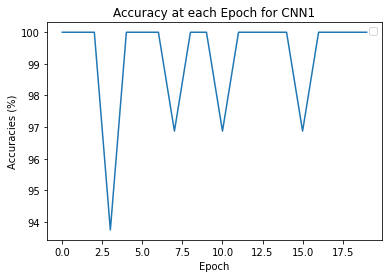

In [74]:
import matplotlib.pyplot as pyplot
import numpy as np


y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Epoch for GoogleNet")
pyplot.ylabel("Accuracies (%)")
pyplot.xlabel("Epoch")
pyplot.plot( y_axis)

pyplot.legend()

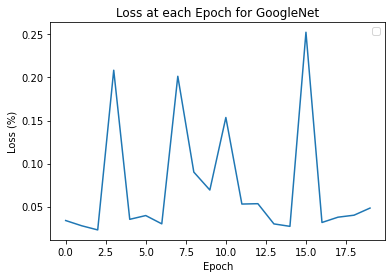

In [79]:
y_axis = np.array(loss_list)

pyplot.title("Loss at each Epoch for GoogleNet")
pyplot.ylabel("Loss (%)")
pyplot.xlabel("Epoch")
pyplot.plot( y_axis)

pyplot.legend()

In [77]:
torch.save(model.state_dict(), '/content/Model/googleNetGTSRB.pth')